Статья:

https://medium.com/@pixc/%D0%BF%D1%80%D0%BE%D1%81%D1%82%D0%BE%D0%B9-%D0%BF%D0%B0%D1%80%D1%81%D0%B5%D1%80-%D0%B2%D0%BA-%D0%BD%D0%B0-python-5f202814eac3

In [ ]:
Что используем для парсинга групп вк? Официальный api.vk.com

# https://api.vk.com/method/wall.get?owner_id=-59014018&count=7&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&v=5.131

In [ ]:
Что используется для анализа сентимента?

1. Онлайн версия rubert-toxic-pikabu-2c, обучен на токсичных комментариях pikabu\2ch

# 2 класса
# https://huggingface.co/sismetanin/rubert-toxic-pikabu-2ch?text=%D0%A2%D1%8B+%D0%BC%D0%BD%D0%B5+%D0%BD%D1%80%D0%B0%D0%B2%D0%B8%D1%88%D1%8C%D1%81%D1%8F.+%D0%AF+%D1%82%D0%B5%D0%B1%D1%8F+%D0%BB%D1%8E%D0%B1%D0%BB%D1%8E

# 5 классов
# https://huggingface.co/cointegrated/rubert-tiny-toxicity?text=%D0%98%D0%B4%D0%B8+%D1%82%D1%8B+%D0%BD%D0%B0%D1%84%D0%B8%D0%B3%21


2. Заведённый на нашем сервере 'rubert-tiny-toxity'

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

model_checkpoint = './rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Пример работы vk api:

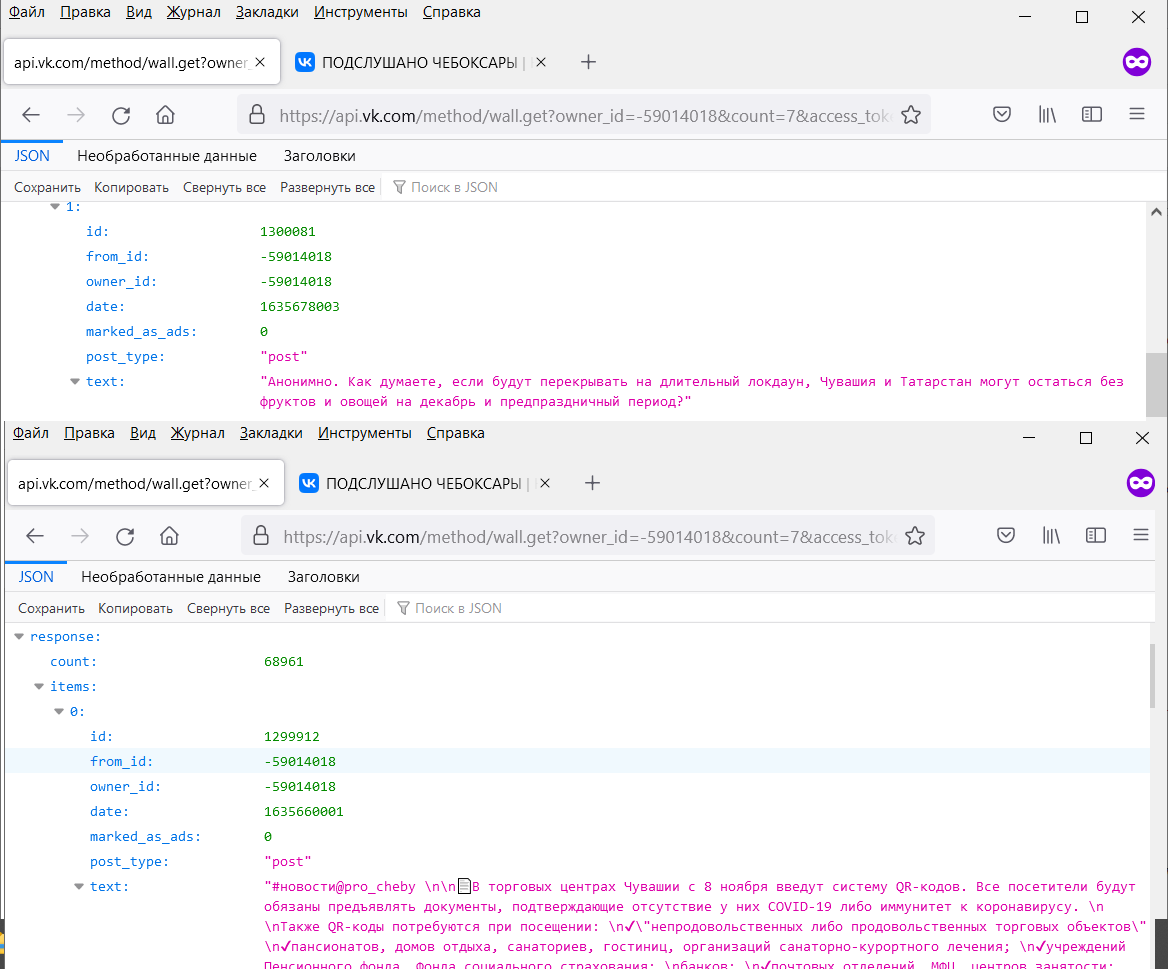

In [199]:
import requests
import json
import re
import pandas as pd
import numpy as np
import torch


from ftfy import fix_text
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.nn import Softmax 

In [348]:
model_checkpoint = './rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


def text2toxicity(text, aggregate=True):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba


### !!!эти функции уже должны быть в коде

def remove_tags(lst):
    for i, text in enumerate(lst):
        tags = ['<passage>', '</passage>', '<hlword>', '</hlword>', '<title>', '</title>', '</url>', '<url>']
        for tag in tags:
            text = fix_text(text.replace(tag, ''))
        lst[i] = text
    return lst

def get_search_engine(key, page):
    query = f'http://xmlproxy.ru/search/xml?query={key}&groupby=attr%3Dd.mode%3Ddeep.groups-on-page%3D5.docs-in-group%3D3&maxpassages=1&page={page}&user=tumanov94%40gmail.com&key=5d1dd64c73beb565044756bd65a9920e'
    r = requests.get(query)

    if r.status_code == 200:
        text = r.text
        titles = re.findall('<title>.*?</title>', text)
        snippets = re.findall('<passage>.*?</passage>', text)
        urls = re.findall('<url>.*?</url>', text)
        
    return list(zip(remove_tags(titles), remove_tags(snippets), remove_tags(urls)))

In [349]:
def return_vk_urls(key):
    vk_urls = []

    for title, snippet, url in get_search_engine(key, 0):
        if 'vk.com' in url:
            vk_urls.append(url)
    return vk_urls

In [351]:
def return_json(query):
    r = requests.get(query)
    if r.ok:
        json_content = json.loads(r.text)
        return json_content

In [352]:
def return_posts_vk(vk_urls):
    vk_url = vk_urls[0]

    if 'wall' in vk_url or 'public' in vk_url or 'club' in vk_url: 
        owner_id = re.search('[0-9]+', vk_url).group(0)
        query_wall = f'https://api.vk.com/method/wall.get?owner_id=-{owner_id}&count=20&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&v=5.131'
        wall_json = return_json(query_wall)
        posts = []
        for post in wall_json['response']['items']:
            post_id = post['id']
            post_text = post['text']
            post_date = post['date']
            query_post_comment = f'https://api.vk.com/method/wall.getComments?owner_id=-{owner_id}&post_id={post_id}&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&v=5.131'
            comments_json = return_json(query_post_comment)

            post_comments = []
            for comment_item in comments_json['response']['items']:
                post_comments.append(comment_item['text'])
            posts.append((post_text, post_date, post_comments))

    else:
        domain = vk_url.replace('https://vk.com/', '')
        query_wall = f'https://api.vk.com/method/wall.get?domain={domain}&count=20&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&v=5.131'
        wall_json = return_json(query_wall)
        owner_id = wall_json['response']['items'][0]['owner_id']
        posts = []
        for post in wall_json['response']['items']:
            post_id = post['id']
            post_text = post['text']
            post_date = post['date']
            query_post_comment = f'https://api.vk.com/method/wall.getComments?owner_id={owner_id}&post_id={post_id}&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&v=5.131'
            comments_json = return_json(query_post_comment)

            post_comments = []
            for comment_item in comments_json['response']['items']:
                post_comments.append(comment_item['text'])
            posts.append((post_text, post_date, post_comments))  
    return posts

In [546]:
def return_posts_df(key):
    vk_urls = return_vk_urls(key)
    
    if len(vk_urls) == 0:
        return 'Данная организация не найдена в сообществах ВКонтакте',''
    else:
        posts = return_posts_vk(vk_urls)
        posts_df = pd.DataFrame(posts, columns=['text', 'date', 'comments'])
        posts_df['bank_cards'] = posts_df['text'].apply(lambda x: len(re.findall(r'[0-9]{4}\s*[0-9]{4}\s*[0-9]{4}\s*[0-9]{4}', x)))
        posts_df['sentiment'] = posts_df['comments'].apply(lambda comments: np.mean([text2toxicity(comment) for comment in comments if comment != '' and 'http' not in comment]) if len(comments) != 0 else np.nan)
        return posts_df, vk_urls[0]

In [547]:
def return_mean_sentiment(df):
    mean_sentiment = df[~df['sentiment'].isnull()]['sentiment'].mean()
    return f'Средняя величина сентимента равна: {round(mean_sentiment, 2) * 100}%'

In [622]:
def return_bank_card_count(df):
    bank_cards_count = df['bank_cards'].sum()
    text_comment = df.loc[(df['bank_cards'] == df['bank_cards'].max()) & (df['bank_cards'] != 0), 'text'].values
    if text_comment:
        text_comment = re.sub(r'\s+', ' ', text_comment[0])
        return f'Количество упоминаний банковских карт или реквизитов в последних 40 (если есть) постах на стене: {bank_cards_count}', f'Пост с упоминанием банковской карты: {text_comment}'
    else:
        return f'Количество упоминаний банковских карт или реквизитов в последних 40 (если есть) постах на стене: {bank_cards_count}', 'Посты с банковскими картами отсутствуют'

In [623]:
def return_last_post_days_from_now(df):
    days = (datetime.now() - datetime.utcfromtimestamp(df.loc[0, 'date'])).days
    return f'С момента публикации последнего поста прошло {days} дней'

In [641]:
def return_toxic_comments(df):
    comments_sentiment = df.sort_values(by='sentiment', ascending=False)[['comments', 'sentiment']]
    comments_sentiment['comments'] = comments_sentiment['comments'].apply(lambda x: x[0] if x else 0)
    lst_comms = [f'Комментарий: {comment}, сентимент {round(sentiment, 2)}' for comment, sentiment in comments_sentiment.head(5).values if comment]
    lst_comms = [re.sub(r'\s+', ' ', sent) for sent in lst_comms]
    return lst_comms

In [644]:
def return_posts_agg_inform(key):
    posts_df, url = return_posts_df(key)

    if isinstance(posts_df, str):
        return posts_df
    
    elif isinstance(posts_df, pd.DataFrame):
        sentiment = return_mean_sentiment(posts_df)
        cards_count, bank_card_post = return_bank_card_count(posts_df)
        last_post_days = return_last_post_days_from_now(posts_df)
        toxic_comments = return_toxic_comments(posts_df)
        url = f'Ссылка на группу: {url}'
    
    posts_inform = [url, sentiment, cards_count, bank_card_post, last_post_days]
    posts_inform.extend(toxic_comments)
    return posts_inform

In [645]:
name_org = 'Благотворительный фонд аурея'

return_posts_agg_inform(name_org)

['Ссылка на группу: https://vk.com/aureya',
 'Средняя величина сентимента равна: 17.0%',
 'Количество упоминаний банковских карт или реквизитов в последних 40 (если есть) постах на стене: 2',
 'Пост с упоминанием банковской карты: Благотворительный сбор для Маши Павловской окончен. Программа закрыта. Спасибо всем, кто помог! Маша родилась 19 марта 2004 года (10 лет) в городе Краснодар. У девочки ДЦП, спастическая диплегия, множественные контрактуры суставов и конечностей. Ей тяжело ходить, также присутствует нарушение походки и деформация стоп. Благотворительная помощь Маше Павловской Маша пережила операцию на тазобедренных суставах и теперь ей нужна постоянная реабилитация, а также дорогостоящее медикаментозное лечение. Мама Маши - Павловская Лариса обратилась в наш Фонд за благотворительной помощью и мы инициировали благотворительный сбор для Марии. Телефон мамы девочки, Людмилы Павловской: (918) 39 66 891 Вы можете перечислить благотворительный взнос на расчетный счет мамы Маши: Сче

In [545]:
model_checkpoint = './rubert-tiny-toxicity'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)


def text2toxicity(text, aggregate=True):
    """ Calculate toxicity of a text (if aggregate=True) or a vector of toxicity aspects (if aggregate=False)"""
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(model.device)
        proba = torch.sigmoid(model(**inputs).logits).cpu().numpy()
    if isinstance(text, str):
        proba = proba[0]
    if aggregate:
        return 1 - proba.T[0] * (1 - proba.T[-1])
    return proba

In [544]:
text2toxicity('любовь')

0.0210785186412924

In [476]:
name_org = 'Благотворительный фонд дедморозим'

In [477]:
def return_desc_group(name_org):
    vk_urls = return_vk_urls(name_org)
    if len(vk_urls) == 0:
        return 'Группа не найдена'
    
    else:
        vk_url = vk_urls[0]

        if 'wall' in vk_url or 'public' in vk_url or 'club' in vk_url:
            group_id = re.search('[0-9]+', vk_url).group(0)
        else:
            group_id = vk_url.replace('https://vk.com/', '')

        group_info_query = f'https://api.vk.com/method/groups.getById?v=5.95&fields=members_count,description,contacts&access_token=01ef402201ef402201ef4022960188fca3001ef01ef40225dccc46d44b32b92b49fee92&group_id={group_id}'
        group_info_json = return_json(group_info_query)
        group_description = group_info_json['response'][0]['description']
        group_description = re.sub('\s+', ' ', group_description)
        return group_description

In [478]:
return_desc_group(name_org)

'«Дедморозим» объединяет людей ради совершения чудес для детей-сирот и ребят со смертельно опасными заболеваниями. Никто не обязан помогать другим. Но это чудо, когда такой шанс есть. Фонд создан в 2012 году обычными людьми, к его появлению не имеют отношения какие-либо государственные, политические или бизнес-структуры и деятели. Достижения «Дедморозим» в равной степени принадлежат всем участникам помощи детям. «Дедморозим» — это вы. Проекты «Дедморозим»: https://dedmorozim.ru/projects/ Как помочь: https://dedmorozim.ru/dedmorozit/ Стать фото- или автоволонтёром: https://dedmorozim.ru/volonteru/ Отчёты: https://dedmorozim.ru/report/'